In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread(r"D:\6m_NIC\images\apple1.jpg")

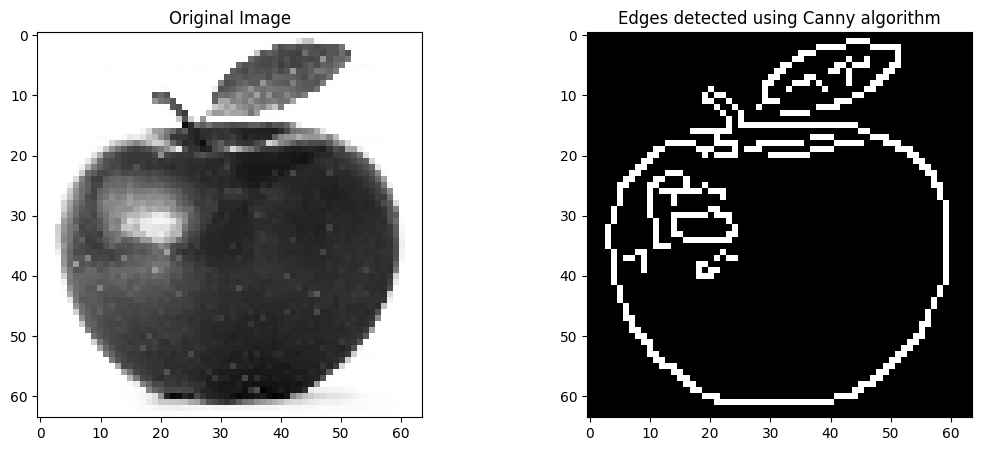

In [32]:
import cv2
import matplotlib.pyplot as plt

# Assuming image is already in grayscale and correctly loaded

# Ensure the image is in 8-bit format (if it's not already)
image = (image * 255).astype(np.uint8)

def detect_edges(image, low_threshold=100, high_threshold=200):
    # Apply the Canny edge detection
    edges = cv2.Canny(image, low_threshold, high_threshold)
    
    # Plot the original and edge-detected images
    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges detected using Canny algorithm')
    plt.show()

detect_edges(image)


In [7]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
import numpy as np
import matplotlib.pyplot as plt

(64, 64)

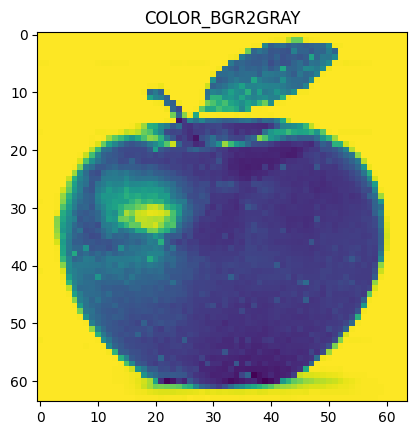

In [8]:
image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Resize the image
image = cv2.resize(image, (64, 64))
image = np.array(image) / 255.0
plt.title('COLOR_BGR2GRAY')
plt.imshow(image)
image.shape

In [9]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1))) #first np.sum of each row elements then np.sum of each row

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [ ]:
from qiskit.visualization import array_to_latex
# Horizontal: Original image
h_norm_image = amplitude_encode(image)
print("Horizontal image normalized coefficients")
array_to_latex(h_norm_image,max_size=10)

In [12]:
# Vertical: Transpose of Original image
v_norm_image = amplitude_encode(image.T)
print("vertical image normalized coefficients")
array_to_latex(v_norm_image,max_size=10)

vertical image normalized coefficients


<IPython.core.display.Latex object>

In [13]:
print("size of 1d array",h_norm_image.shape)
print("size of 1d array",v_norm_image.shape)

size of 1d array (4096,)
size of 1d array (4096,)


In [14]:
#we require N=log2(64*64) qubits
#N=16

data_q = 12
ancillary_q = 1
total_q = data_q + ancillary_q

In [15]:
# Initialize the amplitude permutation unitary
#Decrement Gate
D2n_1 = np.roll(np.identity(2**total_q), 1, axis=1) #np.roll performs a circular shift of the columns of the identity matrix by one positions

In [16]:
D2n_1.shape

(8192, 8192)

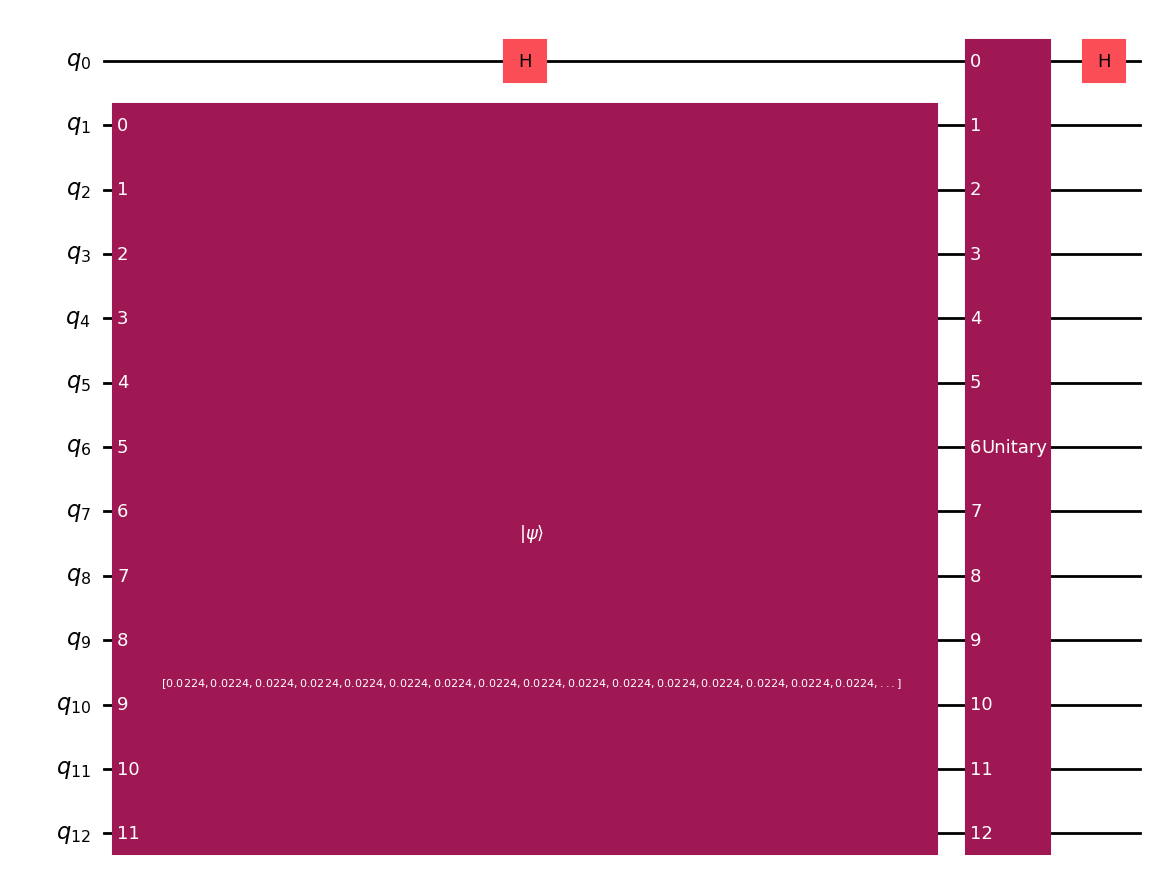

In [17]:
# Creating the circuit for horizontal scan

qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_q))
qc_h.h(0)

display(qc_h.draw('mpl', fold=-1))

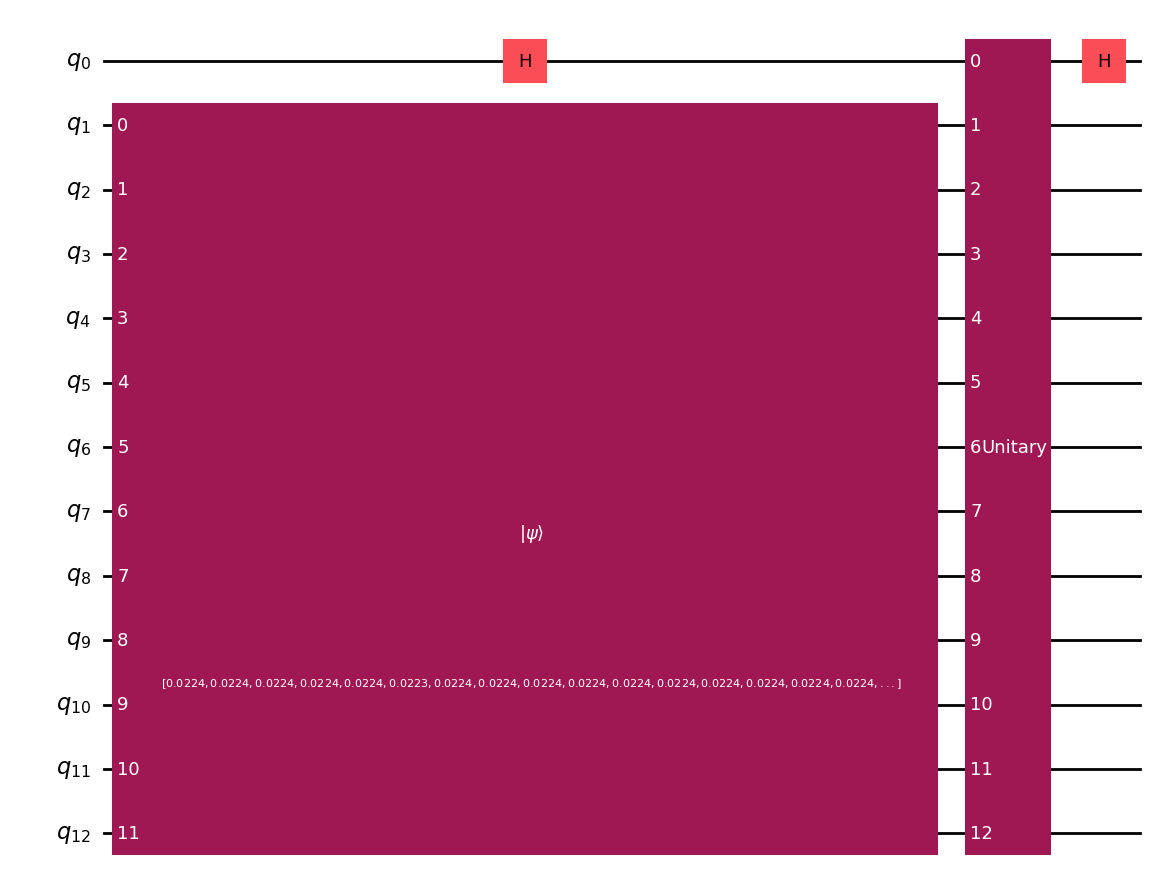

In [18]:
# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_q))
qc_v.h(0)

display(qc_v.draw('mpl', fold=-1))

In [19]:
# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [23]:
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex

# Use the 'statevector_simulator' backend
back = Aer.get_backend('statevector_simulator')

# Run the simulation for each circuit individually to avoid memory issues
result_h = back.run(qc_h).result()
result_v = back.run(qc_v).result()

# Retrieve the state vectors for horizontal and vertical scans
state_vector_h = result_h.get_statevector(qc_h)
state_vector_v = result_v.get_statevector(qc_v)

# Print the size of the state vector to check memory usage
print("Size of horizontal scan statevector:", state_vector_h.size)
print("Size of vertical scan statevector:", state_vector_v.size)

# Display the state vectors
print('Horizontal scan statevector:')
display(array_to_latex(state_vector_h, max_size=128))
print()
print('Vertical scan statevector:')
display(array_to_latex(state_vector_v, max_size=128))


C:\Users\DELL\AppData\Local\Temp\ipykernel_9260\1670189801.py:16: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Size of horizontal scan statevector:", state_vector_h.size)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9260\1670189801.py:17: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("Size of vertical scan statevector:", state_vector_v.size)


Size of horizontal scan statevector: 8192
Size of vertical scan statevector: 8192
Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

In [24]:
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='hot')
    plt.show()

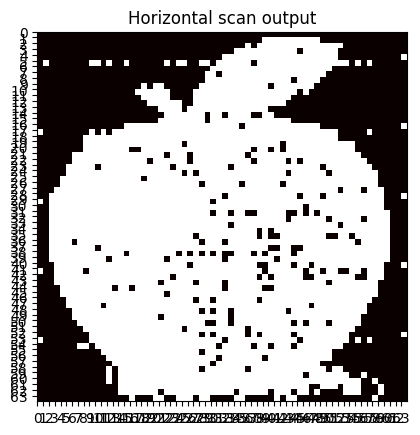

In [25]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)


h_edge_scan_img = np.abs(np.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(64, 64)

# Plotting the Horizontal scan output
plot_image(h_edge_scan_img, 'Horizontal scan output')

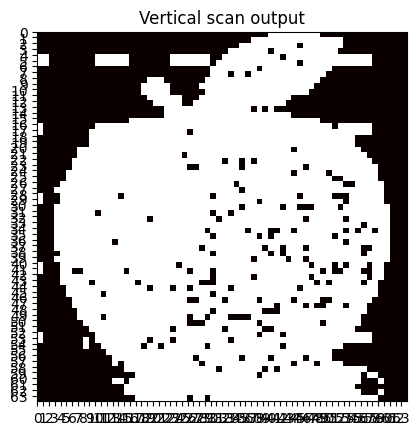

In [26]:
v_edge_scan_img= np.abs(np.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(64, 64).T
plot_image(v_edge_scan_img, 'Vertical scan output')

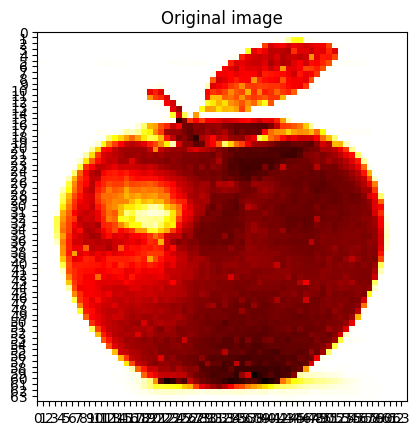

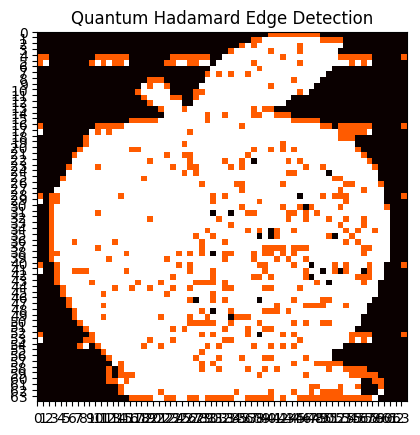

In [27]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = h_edge_scan_img + v_edge_scan_img

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Quantum Hadamard Edge Detection')